In [124]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime as dt
import re
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt 
from datetime import datetime

yf.pdr_override()

# Get html code of website that has stock list for S&P 500
url = 'https://www.slickcharts.com/sp500'
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'}
r = requests.get(url, headers = headers)
soup = BeautifulSoup(r.text, 'html')

# Find the table holding the list of stocks
table = soup.find('table')
temp = pd.read_html(table.prettify())
sp = pd.DataFrame(temp[0])

# Put the stock symbols into one list
stockList = []
for idx, row in sp.iterrows():
    sym = row['Symbol']
    sym = sym.replace('.','-')
    stockList.append(sym)

# Set up time objects
now = dt.datetime.now()
end = dt.datetime(now.year,now.month-2,now.day)
start = dt.datetime(now.year, now.month-4, now.day)

totReturns = [] # list of strategy returns
totStraight = [] # list of straight stock returns
usedStocks = [] # list of stocks that we could gather data from
# Go through each stock in list and test the purchasing setup
for stock in stockList:
    df = pdr.get_data_yahoo(stock,start,end)
    

    # Get rid of columns that are not of use and only taking up space
    df.drop('Open', inplace=True, axis=1)
    df.drop('Close', inplace=True, axis=1)
    df.drop('Volume', inplace=True, axis=1)

    # Create column of rolling highs and lows (High/Low over past 10 days)
    df['L10'] = df['Low'].rolling(window=10).min()
    df['H10'] = df['High'].rolling(window=10).max()

    # Calculate %K and %D (part of stochastic measure)
    df['%K'] = 100*((df['Adj Close'] - df['L10']) / (df['H10'] - df['L10']))
    df['%D'] = df['%K'].rolling(window=4).mean()

    # Column to determine when to buy the stock 
    # (if %K crosses through %D line and %D < 20)
    df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 25)

    # Initialize Long to 0
    df['Long'] = 0

    own = 0
    stopLoss = 0
    prevClose = 0
    tempRet = 0 # Temporary returns on the position
    returns = []
    for idx, row in df.iterrows():
        if row['Buy Entry'] and own == 0:
            # Buy the stock
            own = 1
            df['Long'][idx] = 1
            stopLoss = 0.92 * row['Adj Close']
            tempRet = 0
        elif stopLoss > row['Adj Close']:
            # Sell the stock
            own = 0
            df['Long'][idx] = 0
            stopLoss = 0
            returns.append(tempRet)
            tempRet = 0
        elif own == 1:
            # Check if we need to update our stop loss
            df['Long'][idx] = 1
            tempRet = tempRet + (100 * (row['Adj Close'] - prevClose) / prevClose)
            tempStopLoss = 0.92 * row['Adj Close']
            if tempStopLoss > stopLoss:
               stopLoss = tempStopLoss
        prevClose = row['Adj Close']
    returns.append(tempRet) # Add the final return to total return

    if not(df.empty):
        totReturns.append(sum(returns))
        totStraight.append(100* (df['Adj Close'].iloc[-1] - df['Adj Close'].iloc[0]) / df['Adj Close'].iloc[0])
        usedStocks.append(stock)

data = pd.DataFrame()
data['Stock'] = usedStocks
data['Strategy Return'] = totReturns
data['Stock Return'] = totStraight
print(data)


*******************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********

In [4]:
data

,Stock,Strategy Return,Stock Return
0,AAPL,3.872632,5.324700
1,MSFT,4.297370,4.713240
2,AMZN,6.387641,4.909487
3,FB,-0.464593,2.128962
4,GOOGL,4.303690,2.587320
...,...,...,...
501,HFC,0.345560,-20.037732
502,UAA,0.000000,23.400189
503,UA,0.000000,19.659941
504,NWS,-2.641899,-7.952686


In [6]:
# Get number of times strategy was better than the straight stock
count = 0
for index, row in data.iterrows():
    if row['Strategy Return'] > row['Stock Return']:
        count = count + 1
print(count)

342


342/505

In [11]:
#Get average gain/loss of strategy and straight stock
print(data['Strategy Return'].mean())
print(data['Stock Return'].mean())

5.570530314175897
2.7767766993109158


<AxesSubplot:title={'center':'Strategy Return vs. Stock Return'}, xlabel='Strategy Return', ylabel='Stock Return'>

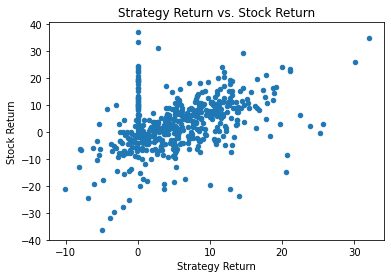

In [14]:
#Create a scatterplot of startegy returns vs. stock returns
import matplotlib.pyplot as plt
data.plot(x = 'Strategy Return',y='Stock Return', kind = 'scatter', title = 'Strategy Return vs. Stock Return')